In [ ]:
import cv2
import argparse
import json
import numpy as np
from tqdm import tqdm
from os.path import exists
import os

from segment_anything import sam_model_registry
from automatic_mask_generator import SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        x0, y0, w, h = ann['bbox']
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
        ax.scatter([x0+w//2], [y0+h//2], color='green', marker='*', s=10, edgecolor='white', linewidth=1.25)

In [ ]:
data_path = 'data/FSC147/'
anno_file = data_path + 'annotation_FSC147_384.json'
data_split_file = data_path + 'Train_Test_Val_FSC_147.json'
im_dir = data_path + 'images_384_VarV2'
model_type = 'vit_h'
model_path = 'data/pretrainedModels/sam_vit_h_4b8939.pth'

if not exists(anno_file) or not exists(im_dir):
    print("Make sure you set up the --data-path correctly.")
    print("Current setting is {}, but the image dir and annotation file do not exist.".format(data_path))
    print("Aborting the evaluation")
    assert False

In [ ]:
# change this if you want to run on other gpus
device = 'cuda'
sam = sam_model_registry[model_type](checkpoint=model_path)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
                                model=sam,
                                min_mask_region_area=25
                                )

In [ ]:
with open(anno_file) as f:
    annotations = json.load(f)

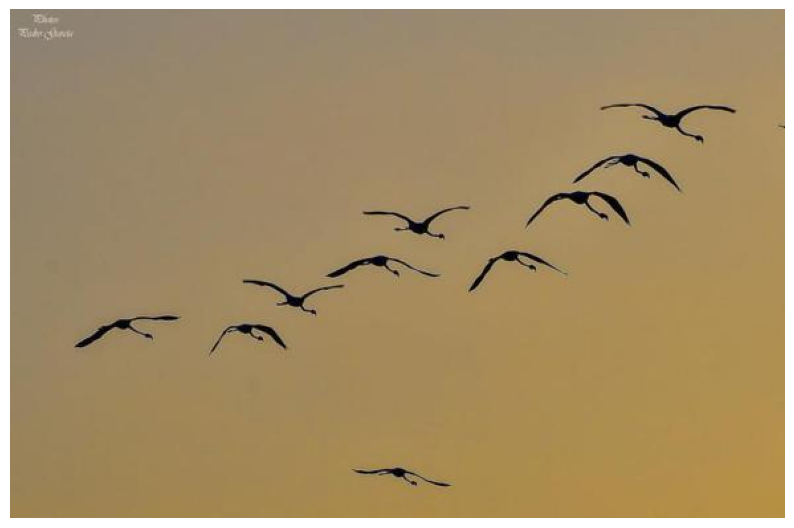

In [ ]:
# change this if you want to vis other image
im_id = '580.jpg'
image = cv2.imread('{}/{}'.format(im_dir, im_id))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

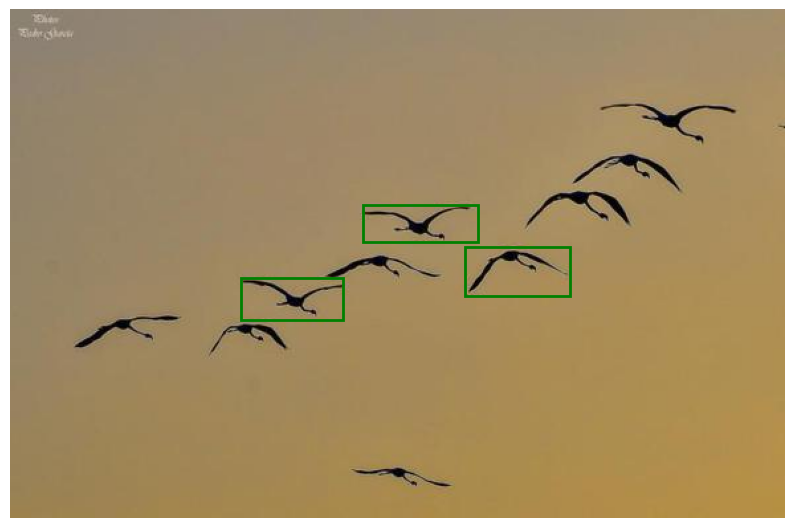

In [ ]:
# show example boxes
anno = annotations[im_id]
bboxes = anno['box_examples_coordinates']
dots = np.array(anno['points'])

input_boxes = list()
for bbox in bboxes:
    x1, y1 = bbox[0][0], bbox[0][1]
    x2, y2 = bbox[2][0], bbox[2][1]
    input_boxes.append([x1, y1, x2, y2])

plt.figure(figsize=(10,10))
plt.imshow(image)
ax = plt.gca()
ax.set_autoscale_on(False)
for i in input_boxes:
    ax.add_patch(plt.Rectangle((i[0],i[1]), i[2]-i[0], i[3]-i[1], edgecolor='green', facecolor=(0,0,0,0), lw=2))
plt.axis('off')
plt.show()
plt.close()

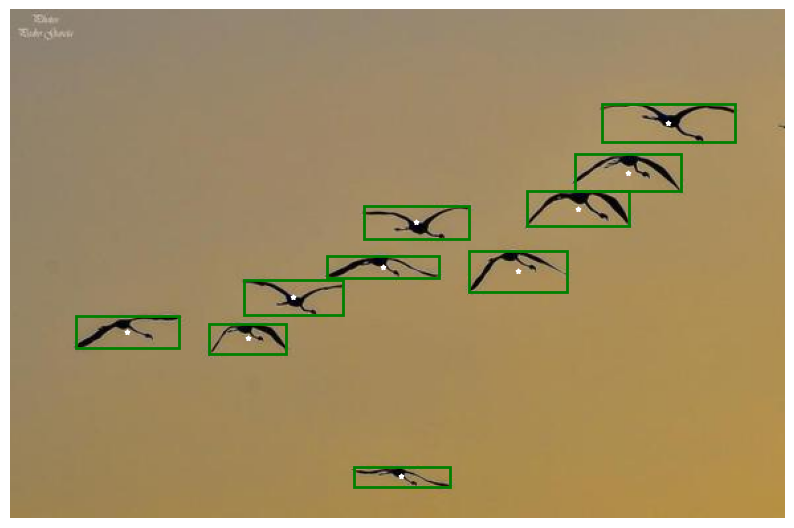

In [ ]:
# process and show predicted boxes
masks = mask_generator.generate(image, input_boxes)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
# show segment results
color = [
    [30,144,255], # aorta
    [0,255,0],    # gallbladder
    [255,0,0],    # left kidney
    [0,255,255], # right kidney
    [255,0,255],  # liver
    [255,255,0],  # pancreas
    [128,0,255],  # spleen
    [255,128,0],  # stomach
]
cnt=0    
plt.figure(figsize=(10,10))
plt.imshow(image)    
plt.axis('off')
box = np.zeros_like(image)
for i in masks:
    seg = i['segmentation'].reshape(i['segmentation'].shape[0],i['segmentation'].shape[1],1)#.repeat(3,axis=2)
    box = np.where(seg,color[cnt],box)
    cnt += 1
    cnt %= len(color)
plt.imshow(box,alpha=0.5)
show_anns(masks)